In [1]:
# Force garbage collection
import gc
gc.collect()

34

In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [3]:
import os
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import roc_curve
import itertools

In [5]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [6]:
import warnings

In [7]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [8]:
# read the merged data
# mod_data = pd.read_parquet('../Clean_Data/Model_Data/2001_2020_Downsample/Features_w_Label_Downsampled.parquet')
#Eval_data = pd.read_parquet('../Clean_Data/Model_Data/2020/Features_w_Label_2020_OOT.parquet')
Eval_data = pd.read_parquet('../Clean_Data/Model_Data/Evaluation/Features_w_Label/2020_features_w_label.parquet')

In [9]:
# convert NWCG_CAUSE_CLASSIFICATION to string
Eval_data['NWCG_CAUSE_CLASSIFICATION'] = Eval_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)

In [10]:
print("Before filtering")
Eval_data['NWCG_CAUSE_CLASSIFICATION'].value_counts()

Before filtering


NWCG_CAUSE_CLASSIFICATION
None                                                    6284671
'Human'                                                    4113
'Missing data/not specified/undetermined'                  3869
'Natural'                                                   551
'Human', 'Missing data/not specified/undetermined'           93
'Missing data/not specified/undetermined', 'Natural'          3
'Human', 'Natural'                                            1
Name: count, dtype: int64

In [11]:
Eval_Human = Eval_data[(Eval_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (Eval_data['IS_FIRE'] == 0)]

In [12]:
print("After filtering")
Eval_Human['NWCG_CAUSE_CLASSIFICATION'].value_counts()

After filtering


NWCG_CAUSE_CLASSIFICATION
None                                                  6284671
'Human'                                                  4113
'Human', 'Missing data/not specified/undetermined'         93
'Human', 'Natural'                                          1
Name: count, dtype: int64

In [13]:
# read ../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_2001_2020.parquet
mod_data = pd.read_parquet('../Clean_Data/Model_Data/Downsample/Features_w_Label/features_w_label_downsample_2001_2020.parquet')

In [14]:
# check mean of IS_FIRE to indicate fire event proportion
print("mod_data IS_FIRE mean")
# using 
print(mod_data['IS_FIRE'].mean())

mod_data IS_FIRE mean
0.009900990099009901


In [15]:
mod_data.shape

(15335234, 32)

In [16]:
mod_data['NWCG_CAUSE_CLASSIFICATION'] = mod_data['NWCG_CAUSE_CLASSIFICATION'].astype(str)

In [17]:
# filter the cause to be either human or is_fire = 0
mod_Human = mod_data[(mod_data['NWCG_CAUSE_CLASSIFICATION'].str.contains('Human')) | (mod_data['IS_FIRE'] == 0)]

In [18]:
mod_Human['NWCG_CAUSE_CLASSIFICATION'].value_counts()

NWCG_CAUSE_CLASSIFICATION
None                                                  15183400
'Human'                                                 102582
'Human', 'Missing data/not specified/undetermined'         740
'Human', 'Natural'                                         104
Name: count, dtype: int64

In [19]:
mod_Human.shape

(15286826, 32)

In [20]:
print(mod_Human['IS_FIRE'].mean())

0.006765694853856517


In [21]:
# from day, get Year
mod_Human['Year'] = mod_Human['day'].dt.year
# keep only 2001-2019
mod_Human = mod_Human[mod_Human['Year'] < 2020]
# check shape
mod_Human.shape

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_6024\1401089145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_Human['Year'] = mod_Human['day'].dt.year


(14527232, 33)

In [22]:
features = ['day','dead_fuel_moisture_1000hr',
                    'dead_fuel_moisture_100hr', 
                    #'pdsi_pre_interpolated',
                    'pdsi', 
                    #'pdsi_class', 
                    'max_air_temperature',
                    'max_relative_humidity', 
                    #'max_wind_speed', 
                    'min_air_temperature',
                    'min_relative_humidity', 
                    'precipitation_amount', 
                    'specific_humidity',
                    'surface_downwelling_shortwave_flux_in_air',
                    'wind_from_direction',
                    'wind_speed', 
                    'wind_direction_category', 
                    'SWE', 
                    'Band1',
                    'LAI',
                    'IS_FIRE',
                    'NWCG_CAUSE_CLASSIFICATION', 
                    'min_FIRE_SIZE', 
                    'max_FIRE_SIZE',
                    'veg_type_details', 
                    'fire_attribute', 
                    'veg', 
                    'slope_avg', 
                    'slope_max',
                    'road_density_km_km2']

In [23]:
mod_Human = mod_Human[features]
Eval_Human = Eval_Human[features]

In [24]:
cat_columns = ['wind_direction_category','veg']

In [25]:
# for mod_data and Eval_date, use one-hot encoding for each column in cat_columns
mod_Human = pd.get_dummies(mod_Human, columns=cat_columns)
Eval_Human = pd.get_dummies(Eval_Human, columns=cat_columns)

In [26]:
# check the % IS_FIRE
mod_Human['IS_FIRE'].value_counts(normalize=True)

IS_FIRE
0    0.99317
1    0.00683
Name: proportion, dtype: float64

In [27]:
Eval_Human['IS_FIRE'].value_counts(normalize=True)

IS_FIRE
0    0.999331
1    0.000669
Name: proportion, dtype: float64

In [28]:
Eval_Human['IS_FIRE'].value_counts()

IS_FIRE
0    6284671
1       4207
Name: count, dtype: int64

In [29]:
mod_Human['day'].min(), mod_Human['day'].max()

(Timestamp('2001-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [30]:
Eval_Human['day'].min(), Eval_Human['day'].max()

(Timestamp('2020-01-01 00:00:00'), Timestamp('2020-12-31 00:00:00'))

In [31]:
not_in_features = ['day',
                    'wind_from_direction',
                    #'wind_direction_category', 
                    'IS_FIRE',
                    'NWCG_CAUSE_CLASSIFICATION', 
                    'min_FIRE_SIZE', 
                    'max_FIRE_SIZE',
                    'veg_type_details', 
                    'fire_attribute']

In [32]:
# print final feature sets 
print("features")
print(mod_Human.columns[~mod_Human.columns.isin(not_in_features)])

features
Index(['dead_fuel_moisture_1000hr', 'dead_fuel_moisture_100hr', 'pdsi',
       'max_air_temperature', 'max_relative_humidity', 'min_air_temperature',
       'min_relative_humidity', 'precipitation_amount', 'specific_humidity',
       'surface_downwelling_shortwave_flux_in_air', 'wind_speed', 'SWE',
       'Band1', 'LAI', 'slope_avg', 'slope_max', 'road_density_km_km2',
       'wind_direction_category_N', 'wind_direction_category_NE',
       'wind_direction_category_E', 'wind_direction_category_SE',
       'wind_direction_category_S', 'wind_direction_category_SW',
       'wind_direction_category_W', 'wind_direction_category_NW',
       'veg_Agriculture ', 'veg_Barren ', 'veg_Native Chapparal ',
       'veg_Native Coastal Sage Scrub ', 'veg_Native Conifer Alpine ',
       'veg_Native Conifer Forest ', 'veg_Native Desert ',
       'veg_Native Grassland ', 'veg_Native Inland Scrub ',
       'veg_Native Oak Woodland ', 'veg_Native Wetland ',
       'veg_Non-native forest ', 'veg_No

In [33]:
# Further split train_val_data into train and validation sets
train_data, val_data = train_test_split(mod_Human, test_size=0.3, shuffle=True, random_state=42)

# Separate features and labels
X_train = train_data.drop(columns=not_in_features)
y_train = train_data['IS_FIRE']
X_val = val_data.drop(columns=not_in_features)
y_val = val_data['IS_FIRE']
# X_oot_downsampled = oot_data_downsampled.drop(columns=['IS_FIRE', 'day'])
# y_oot_downsampled = oot_data_downsampled['IS_FIRE']
X_oot = Eval_Human.drop(columns=not_in_features)
y_oot = Eval_Human['IS_FIRE']

In [34]:
def evaluate_model(model, X_eval, y_eval, plot_precision_recall=False):
    # Predict on evaluation data
    y_eval_pred = model.predict_proba(X_eval)[:, 1]

    # Calculate ROC AUC on evaluation data
    roc_auc = roc_auc_score(y_eval, y_eval_pred)
    print(f'ROC AUC on evaluation data: {roc_auc}')

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_eval, y_eval_pred)
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

    if plot_precision_recall:
        # Plot precision-recall curve
        average_precision = average_precision_score(y_eval, y_eval_pred)
        precision, recall, _ = precision_recall_curve(y_eval, y_eval_pred)
        plt.figure(figsize=(10, 10))
        plt.step(recall, precision, where='post')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
        plt.show()

1. Train a model (without any parameter tuning)

In [35]:
# Train XGBoost model
mod_1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
mod_1.fit(X_train, y_train)

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:19:13] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

ROC AUC on evaluation data: 0.8836872559138557


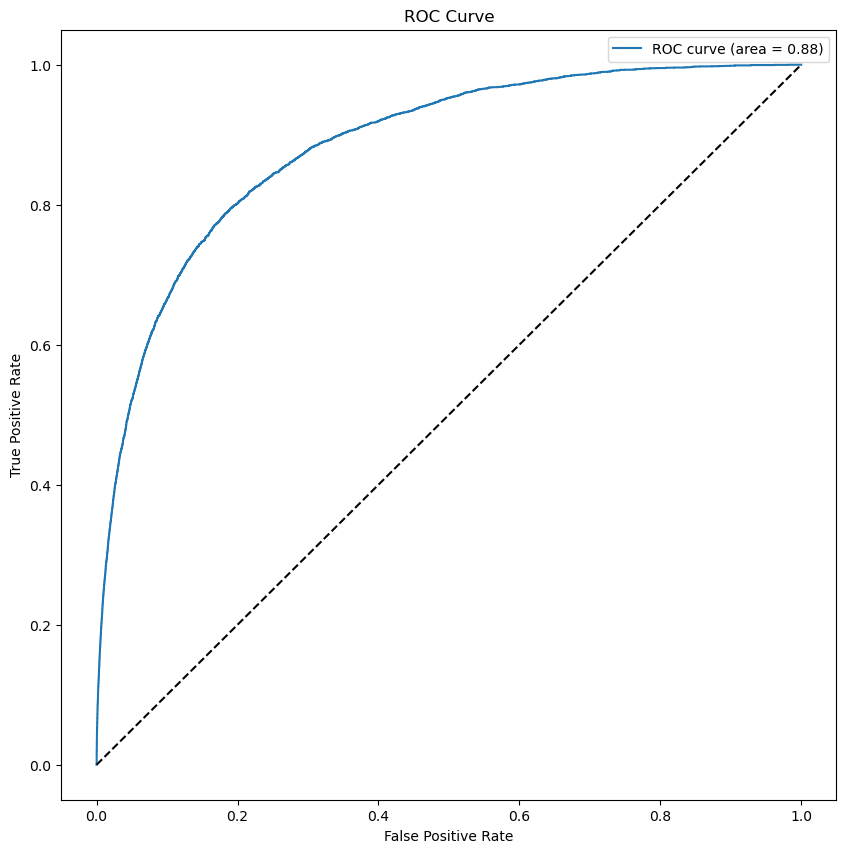

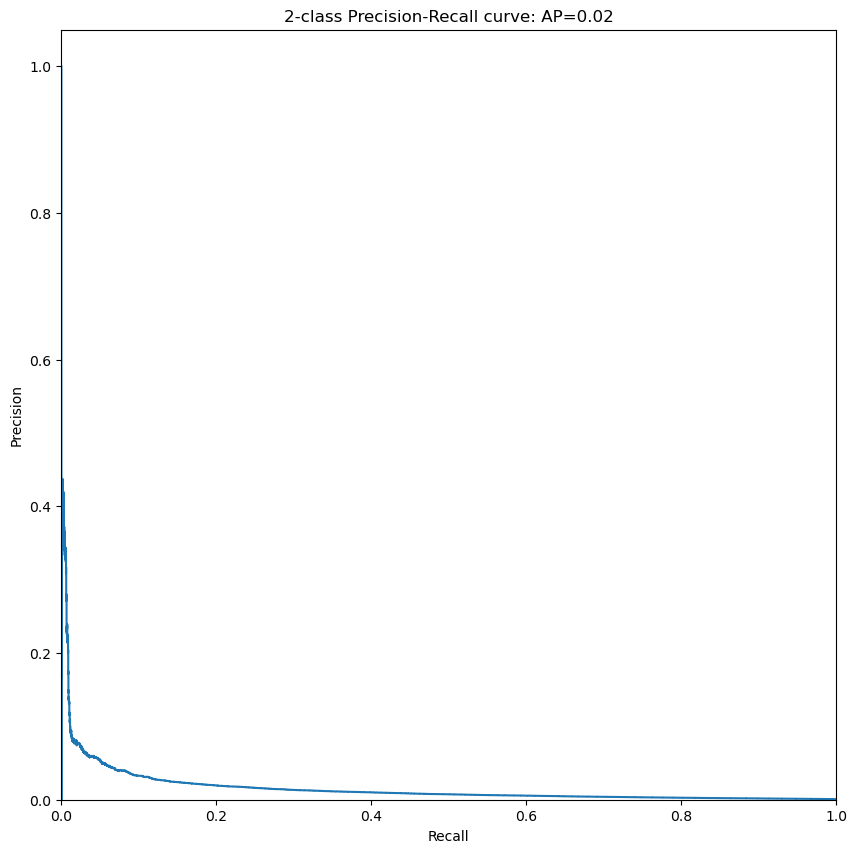

In [36]:
evaluate_model(mod_1, X_oot, y_oot, plot_precision_recall=True)

In [37]:
# print feature importance
feature_importances = pd.Series(mod_1.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print(feature_importances)

Band1                                        0.134693
max_air_temperature                          0.084557
veg_Native Inland Scrub                      0.062589
dead_fuel_moisture_1000hr                    0.059059
road_density_km_km2                          0.037073
SWE                                          0.034160
dead_fuel_moisture_100hr                     0.034082
veg_Agriculture                              0.033228
surface_downwelling_shortwave_flux_in_air    0.026781
wind_direction_category_SW                   0.026769
veg_Native Desert                            0.026288
veg_Native Grassland                         0.025979
veg_Native Conifer Alpine                    0.025002
veg_Non-native grassland                     0.024342
veg_Non-native shrub                         0.023428
veg_Riparian                                 0.023061
slope_avg                                    0.022868
veg_Native Coastal Sage Scrub                0.021489
wind_direction_category_NW  

### Validate if the prediction is consistent with the actual values in spatial-temporal dimension

In [46]:
# add predictions to Eval_Human
Eval_Human['IS_FIRE_PRED'] = mod_1.predict(X_oot)
# use 0.5 as threshold
Eval_Human['IS_FIRE_PRED'] = np.where(Eval_Human['IS_FIRE_PRED'] > 0.5, 1, 0)
# calculate confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_oot, Eval_Human['IS_FIRE_PRED'])
print(confusion)

[[6284433     238]
 [   4168      39]]


In [49]:
# calculate precision and recall
precision = confusion[1, 1] / (confusion[1, 1] + confusion[0, 1])
recall = confusion[1, 1] / (confusion[1, 1] + confusion[1, 0])
# pint in % format
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')            

Precision: 14.08%
Recall: 0.93%


In [53]:
# define function to calculate precision and recall based on a threshold
def calculate_precision_recall(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba > threshold).astype(int)
    confusion = confusion_matrix(y_true, y_pred)
    precision = confusion[1, 1] / (confusion[1, 1] + confusion[0, 1])
    recall = confusion[1, 1] / (confusion[1, 1] + confusion[1, 0])
    # print in % format
    print(f'Threshold: {threshold:.2f}')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    # print confusion matrix w row label and col label
    print("Confusion Matrix")
    print(pd.DataFrame(confusion, index=['True Neg', 'True Pos'], columns=['Pred Neg', 'Pred Pos']))
    return precision, recall

In [58]:
# get the predicted probabilities
y_oot_pred_proba = mod_1.predict_proba(X_oot)[:, 1]
# get the precision and recall for different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
precision_recall_results = []
for threshold in thresholds:
    precision, recall = calculate_precision_recall(y_oot, y_oot_pred_proba, threshold)
    precision_recall_results.append((threshold, precision, recall))
    # print a line
    print("-" * 50)

Threshold: 0.10
Precision: 2.43%
Recall: 14.67%
Confusion Matrix
          Pred Neg  Pred Pos
True Neg   6259921     24750
True Pos      3590       617
--------------------------------------------------
Threshold: 0.20
Precision: 5.91%
Recall: 3.99%
Confusion Matrix
          Pred Neg  Pred Pos
True Neg   6281997      2674
True Pos      4039       168
--------------------------------------------------
Threshold: 0.30
Precision: 8.03%
Recall: 1.62%
Confusion Matrix
          Pred Neg  Pred Pos
True Neg   6283892       779
True Pos      4139        68
--------------------------------------------------
Threshold: 0.40
Precision: 10.85%
Recall: 1.12%
Confusion Matrix
          Pred Neg  Pred Pos
True Neg   6284285       386
True Pos      4160        47
--------------------------------------------------
Threshold: 0.50
Precision: 14.08%
Recall: 0.93%
Confusion Matrix
          Pred Neg  Pred Pos
True Neg   6284433       238
True Pos      4168        39
--------------------------------------

### Performance on Big fire vs Small Fire

In [81]:
Eval_Human['IS_FIRE'].value_counts()

IS_FIRE
0    6284671
1       4207
Name: count, dtype: int64

In [76]:
# when IS_FIRE = 1, check percentile of min_FIRE_SIZE
Eval_Human[Eval_Human['IS_FIRE'] == 1]['min_FIRE_SIZE'].quantile([0.1,0.25,0.5,0.75,0.82,0.9])

0.10    0.05
0.25    0.10
0.50    0.20
0.75    1.00
0.82    1.00
0.90    3.00
Name: min_FIRE_SIZE, dtype: float64

In [77]:
Eval_Big_Fire = Eval_Human[(Eval_Human['max_FIRE_SIZE'] > 1) | (Eval_data['IS_FIRE'] == 0)]

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_22448\1127915682.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Eval_Big_Fire = Eval_Human[(Eval_Human['max_FIRE_SIZE'] > 1) | (Eval_data['IS_FIRE'] == 0)]


In [78]:
Eval_Big_Fire['IS_FIRE'].value_counts()

IS_FIRE
0    6284671
1        738
Name: count, dtype: int64

In [79]:
X_oot = Eval_Big_Fire.drop(columns=not_in_features)
y_oot = Eval_Big_Fire['IS_FIRE']

ROC AUC on evaluation data: 0.8833595729435014


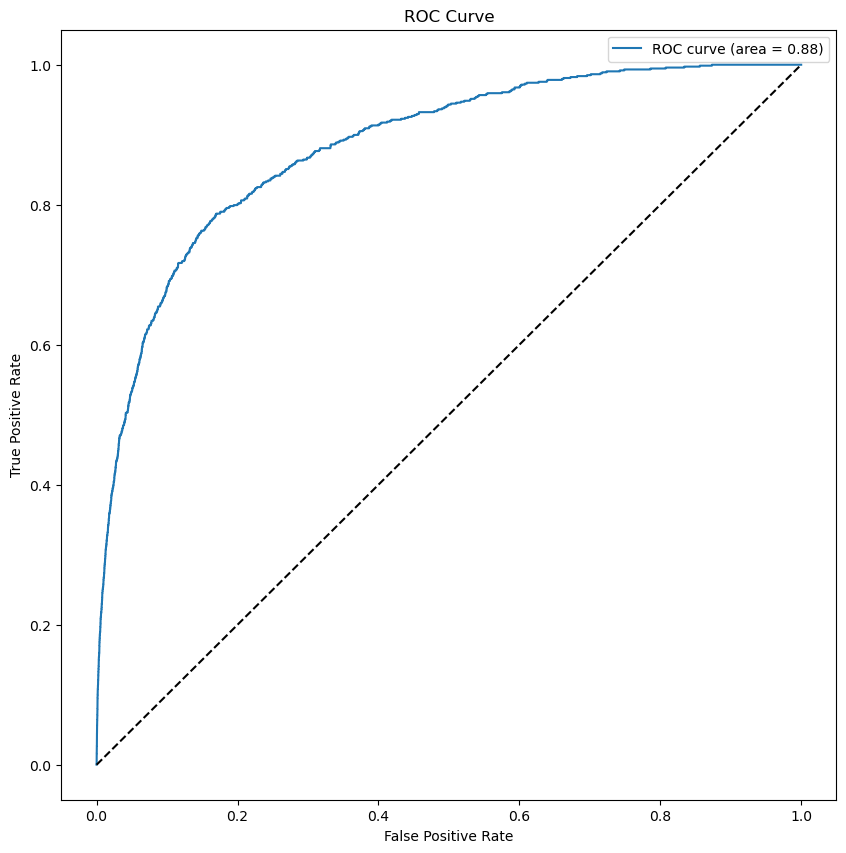

In [80]:
evaluate_model(mod_1, X_oot, y_oot)

## Shap Value

In [85]:
# pip install shap

   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------------------------------------- -- 2.6/2.8 MB 12.6 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 11.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ---- ----------------------------------- 3.4/30.3 MB 18.3 MB/s eta 0:00:02
   -------- ------------------------------- 6.3/30.3 MB 16.8 MB/s eta 0:00:02
   ------------- -------------------------- 10.5/30.3 MB 17.2 MB/s eta 0:00:02
   ----------------- ---------------------- 13.1/30.3 MB 16.1 MB/s eta 0:00:02
   ---------------------- ----------------- 17.0/30.3 MB 16.5 MB/s eta 0:00:01
   ---------------------------- ----------- 21.2/30.3 MB 17.0 MB/s eta 0:00:01
   ---------------------------------- ----- 26.0/30.3 MB 17.7 MB/s eta 0:00:01
   ---------------------------------------  30.1/30.3 MB 18.0 MB/s eta 0:00:01
   ---------------------------------------- 30.3/30.3 MB 17.2 MB/s eta 0:00:0

In [38]:
import shap

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [39]:
X_train.shape, X_oot.shape

((10169062, 42), (6288878, 42))

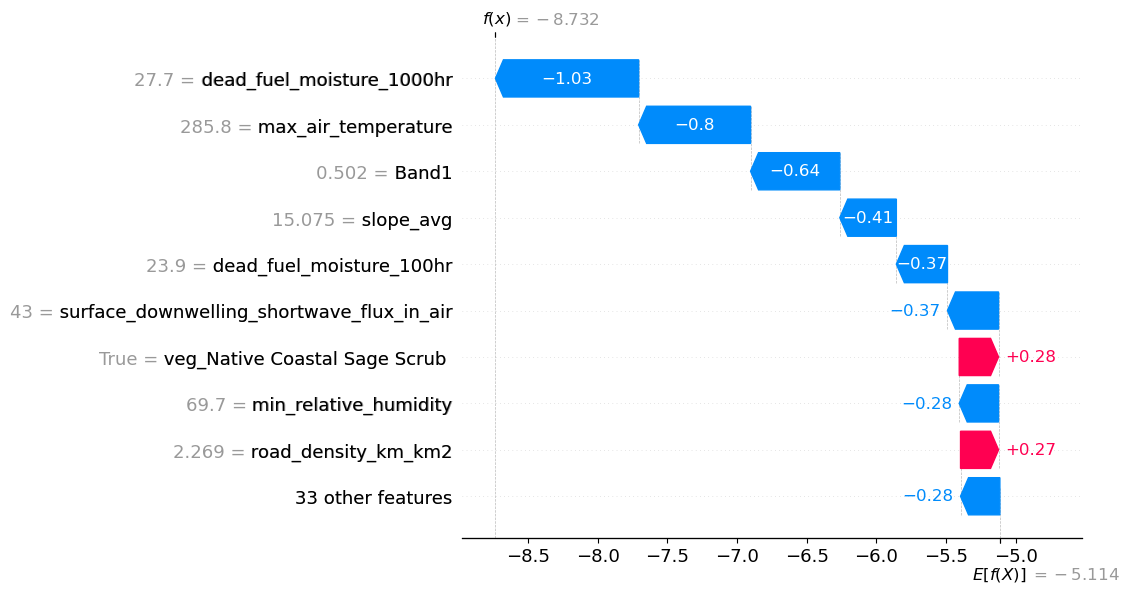

In [40]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(mod_1)
shap_values = explainer(X_oot)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

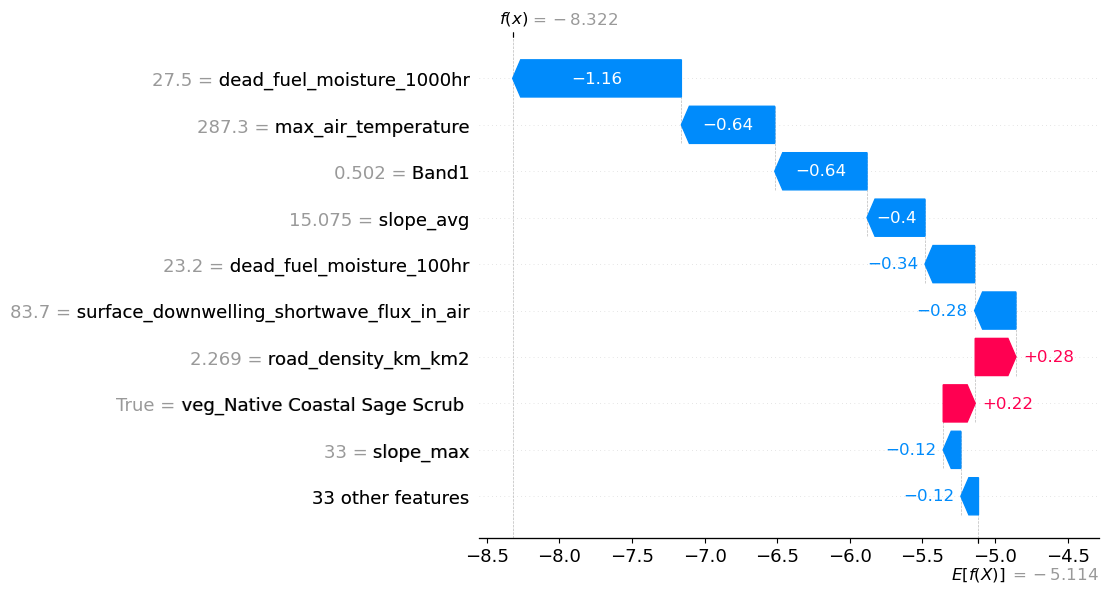

In [41]:
shap.plots.waterfall(shap_values[1])

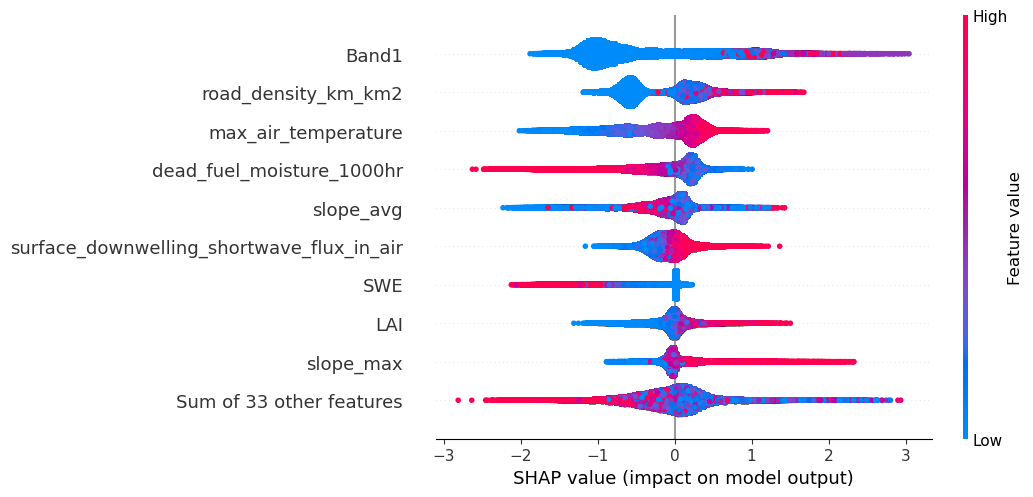

In [42]:
# the beeswarm plot displays SHAP values for each feature across all examples,
# with colors indicating how the SHAP values correlate with feature values
shap.plots.beeswarm(shap_values)

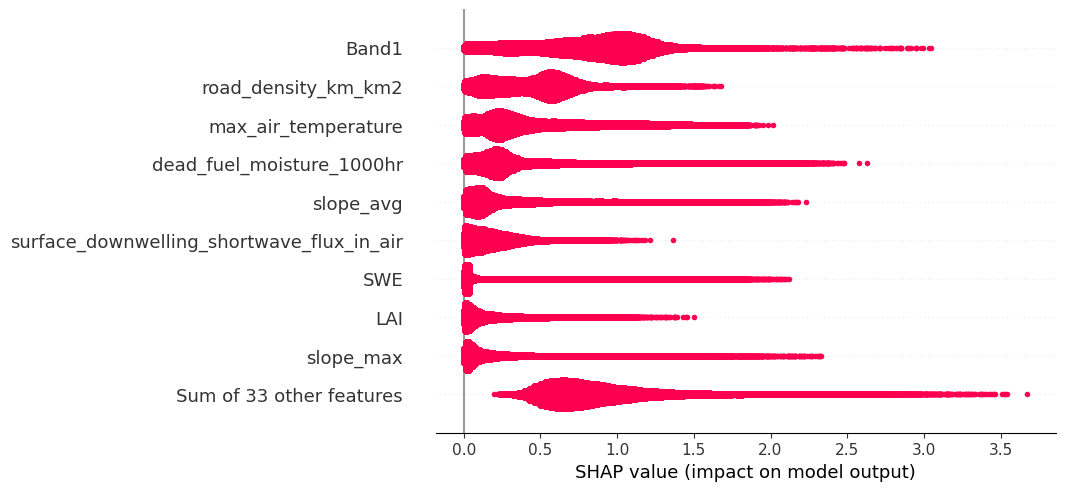

In [43]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

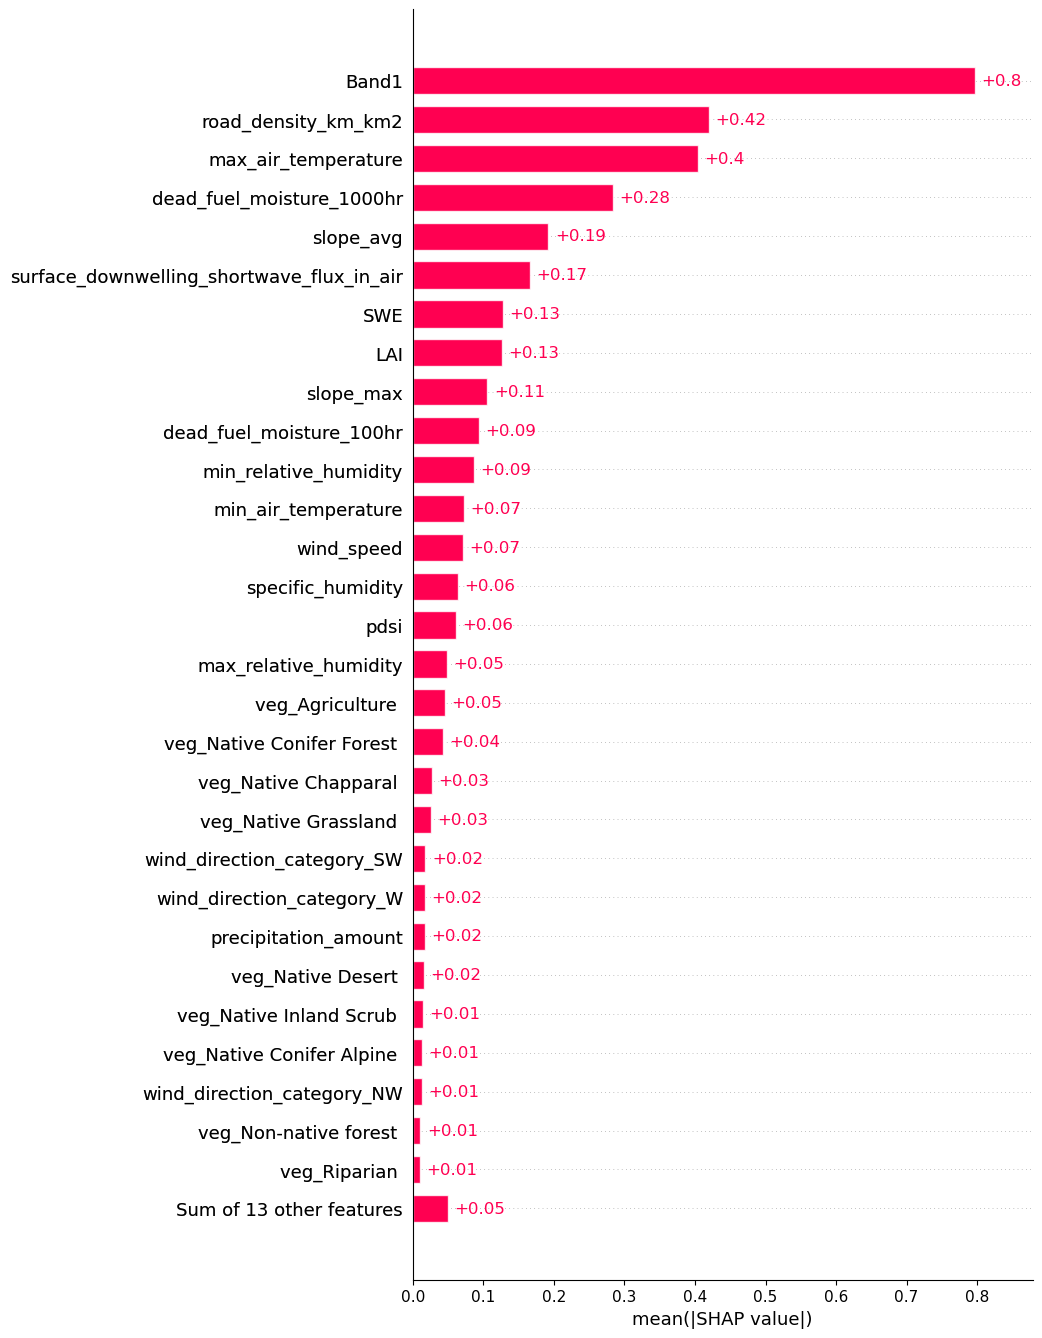

In [44]:
# By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.
shap.plots.bar(shap_values, max_display = 30)

c:\Users\fangshuye\AppData\Local\anaconda3\envs\py311\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


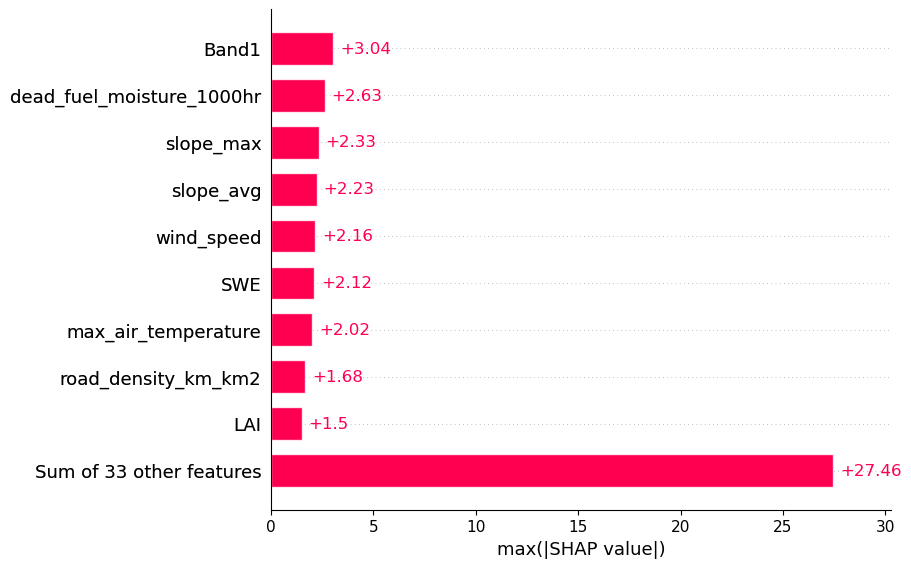

In [45]:
shap.plots.bar(shap_values.abs.max(0))